# Audio File EDA, Image Creation, Pre-processing, FSM

- Converting the the audio files to square Mel-spectrograms, and saving in spectrograms/(BigRoom, DrumAndBass, Techno)
- Applying pre-processing
- FSM CNN with TensorFlow

In [1]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("Blues", as_cmap=True)

# Standard Packages
import numpy as np
import warnings
import pandas as pd
import os
import shutil
import random
import time
import PIL
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#for loading and visualizing audio files
import librosa
import librosa.display
from scipy import signal
from scipy.io import wavfile
import wave

#to play audio
import IPython.display as ipd

### Getting list of genre_names and setting the audio_fpath variable

In [2]:
audio_fpath = "../data/subgenre_dataset/"
genre_names = os.listdir(audio_fpath)
print(genre_names)

['Breaks', 'BigRoom', 'PsyTrance', 'TechHouse', 'ReggaeDub', 'ElectronicaDowntempo', '.DS_Store', 'IndieDanceNuDisco', 'HardcoreHardTechno', 'Trance', 'Minimal', 'ElectroHouse', 'Dance', 'DrumAndBass', 'HipHop', 'GlitchHop', 'House', 'HardDance', 'ProgressiveHouse', 'FutureHouse', 'FunkRAndB', 'Dubstep', 'DeepHouse', 'Techno']


### Getting list of file paths for the 3 selected genres

In [3]:
big_room_file_paths = [audio_fpath + 'BigRoom/' + f for f in os.listdir(audio_fpath + 'BigRoom/') if '.wav' in f]
# big_room_file_paths

In [4]:
dnb_file_paths = [audio_fpath + 'DrumAndBass/' + f for f in os.listdir(audio_fpath + 'DrumAndBass/') if '.wav' in f]
# dnb_file_paths

In [5]:
techno_file_paths = [audio_fpath + 'Techno/' + f for f in os.listdir(audio_fpath + 'Techno/') if '.wav' in f]
# techno_file_paths

## Image pre-processing

### Data has already been train, validate, test split

#### We use Generators because we want to be able to expand this to larger datasets
This means we need to use fit_generator and predict_generator functions during training and testing

In [6]:
# Setting batch size to 1/10 the size of the dataset. Image width and height already loads in as 256x256

batch_size = 30
img_height = 256
img_width = 256
num_channels = 1  # It is grayscale. RGB would be 3


# Set the root directory containing the subdirectories for each class
root_dir = '../spectrograms/'

# Create the train, validation, and test directories
train_dir = root_dir + 'train/'
val_dir = root_dir + 'validate/'
test_dir = root_dir + 'test/'

#### Without rescaling

In [7]:
# Create data generators for the train, validation, and test sets

# Need to look into the rescale value. This is the scaling used for color images. Should it be different for grayscale?

train_data_gen = ImageDataGenerator().flow_from_directory(
        directory=train_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

validation_data_gen = ImageDataGenerator().flow_from_directory(
        directory=val_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

test_data_gen = ImageDataGenerator().flow_from_directory(
        directory=test_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

Found 240 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


#### With Re-scaling

In [8]:
# # Create data generators for the train, validation, and test sets

# # Need to look into the rescale value. This is the scaling used for color images. Should it be different for grayscale?

# train_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         directory=train_dir,
#         target_size=(img_height, img_width),
#         color_mode='grayscale',
#         batch_size=batch_size,
#         class_mode='categorical')

# validation_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         directory=val_dir,
#         target_size=(img_height, img_width),
#         color_mode='grayscale',
#         batch_size=batch_size,
#         class_mode='categorical')

# test_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         directory=test_dir,
#         target_size=(img_height, img_width),
#         color_mode='grayscale',
#         batch_size=batch_size,
#         class_mode='categorical')

## FIRST FSM

In [9]:
lr = 1e-3
stride = 2
padding = 'same'     # Temporary padding selection - STILL NEED TO IMPLEMENT
kernel_size = (3, 3)

In [10]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, num_channels)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 128)               3

### 8 Epochs first CNN Training

In [14]:
start_time = time.time()
history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=train_data_gen.samples // batch_size,
        epochs=8,
        validation_data=validation_data_gen,
        validation_steps=validation_data_gen.samples // batch_size,
        workers=8,
)
print(time.time() - start_time)

Epoch 1/8
8/8 [==============================] - 65s 7s/step - loss: 1706.9534 - acc: 0.3458 - val_loss: 30.5475 - val_acc: 0.3333
Epoch 2/8
8/8 [==============================] - 51s 5s/step - loss: 6.4888 - acc: 0.4333 - val_loss: 0.9275 - val_acc: 0.4667
Epoch 3/8
8/8 [==============================] - 51s 5s/step - loss: 0.8265 - acc: 0.6000 - val_loss: 1.1902 - val_acc: 0.4333
Epoch 4/8
8/8 [==============================] - 41s 4s/step - loss: 1.1554 - acc: 0.7167 - val_loss: 1.7135 - val_acc: 0.5000
Epoch 5/8
8/8 [==============================] - 42s 4s/step - loss: 0.2277 - acc: 0.9458 - val_loss: 1.2347 - val_acc: 0.6333
Epoch 6/8
8/8 [==============================] - 51s 5s/step - loss: 0.0797 - acc: 0.9750 - val_loss: 1.7021 - val_acc: 0.5667
Epoch 7/8
8/8 [==============================] - 51s 5s/step - loss: 0.0659 - acc: 0.9875 - val_loss: 2.3909 - val_acc: 0.4667
Epoch 8/8
8/8 [==============================] - 51s 5s/step - loss: 0.0991 - acc: 0.9792 - val_loss: 2.521

In [15]:
# model_loss, model_acc = model.evaluate_generator(test_data_gen, steps=len(test_data_gen))
# print('Model evaluation accuracy:', model_acc)

In [16]:
# Get the predictions for the test set
test_predictions_percentages = model.predict_generator(test_data_gen, steps=test_data_gen.samples // batch_size + 1)
test_predictions = np.argmax(test_predictions_percentages, axis=1)

# Get the true labels for the test set
test_labels = test_data_gen.classes

In [17]:
for x in range(len(test_predictions)):
    print('Iteration ' + str(x) + '. Label: ' + str(test_labels[x]) + '. Prediction: ' + str(test_predictions[x]))
    print('Prediction percentages: ', test_predictions_percentages[x])

Iteration 0. Label: 0. Prediction: 0
Prediction percentages:  [0.85648847 0.09955225 0.04395939]
Iteration 1. Label: 0. Prediction: 2
Prediction percentages:  [0.07231608 0.05130712 0.87637675]
Iteration 2. Label: 0. Prediction: 1
Prediction percentages:  [0.37922925 0.3898183  0.23095247]
Iteration 3. Label: 0. Prediction: 2
Prediction percentages:  [4.7673592e-03 9.9070756e-05 9.9513358e-01]
Iteration 4. Label: 0. Prediction: 0
Prediction percentages:  [0.6262949  0.00100976 0.37269533]
Iteration 5. Label: 0. Prediction: 0
Prediction percentages:  [0.84631944 0.02338425 0.13029626]
Iteration 6. Label: 0. Prediction: 0
Prediction percentages:  [0.8507328  0.04574756 0.1035196 ]
Iteration 7. Label: 0. Prediction: 2
Prediction percentages:  [1.7633309e-07 4.6277712e-08 9.9999976e-01]
Iteration 8. Label: 0. Prediction: 2
Prediction percentages:  [1.0076894e-07 1.4279868e-08 9.9999988e-01]
Iteration 9. Label: 0. Prediction: 1
Prediction percentages:  [0.01929662 0.563137   0.41756636]
Ite

The accuracy on the test set is: 0.4


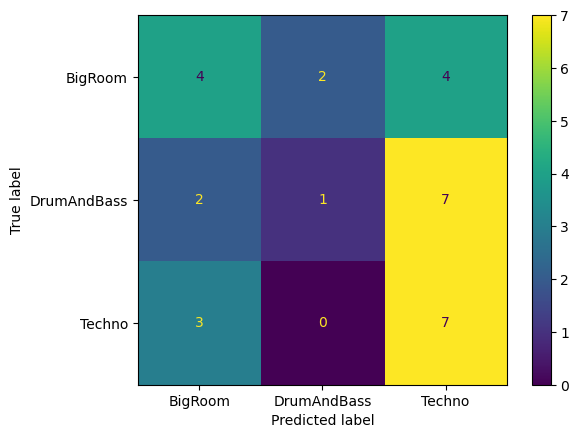

In [18]:
print('The accuracy on the test set is: ' + str(accuracy_score(test_labels, test_predictions)))

# Create the confusion matrix
confusion_mtx = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=['BigRoom', 'DrumAndBass', 'Techno'])

# Plot the confusion matrix
disp.plot()

In [19]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

### SAVE AND LOAD MODEL

In [20]:
model.save('../models/fsm_cnn_8_epochs_80_10_10_adam_categorical_crossentropy_accuracy_no_rescale.h5')

In [22]:
# Loading in the saved model
saved_model = load_model('../models/fsm_cnn_8_epochs_80_10_10_adam_categorical_crossentropy_accuracy_no_rescale.h5')

# FSM 1 HAS AN ACCURACY OF 40%